Analysis face

In [5]:
import argparse
import json
import os
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import cv2
import face_recognition
import numpy as np

In [8]:
ROOT = Path.cwd()

DEFAULT_OUT_DIR = ROOT / "result" / "analysis"
DEFAULT_OUT_DIR.mkdir(parents=True, exist_ok=True)

TEST_DIR = ROOT / "test"
TEST_DIR.mkdir(parents=True, exist_ok=True)

In [20]:
def _box_area(box: Tuple[int, int, int, int]) -> int:
    top, right, bottom, left = box
    return max(0, bottom - top) * max(0, right - left)
    
def _load_image_rgb(image_path: str) -> np.ndarray:
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Khong tim thay anh: {image_path}")
    return face_recognition.load_image_file(image_path)

def _detect_faces(
    image_rgb: np.ndarray,
    detect_model: str = "cnn",
    upsample: int = 0,
) -> List[Tuple[int, int, int, int]]:
    return face_recognition.face_locations(
        image_rgb,
        number_of_times_to_upsample=upsample,
        model=detect_model,
    )

def _encode_faces(
    image_rgb: np.ndarray,
    boxes: List[Tuple[int, int, int, int]],
    landmarks_model: str = "large",
) -> List[np.ndarray]:
    return face_recognition.face_encodings(
        image_rgb,
        known_face_locations=boxes,
        model=landmarks_model,
    )

def _collect_landmarks(
    image_rgb: np.ndarray,
    boxes: List[Tuple[int, int, int, int]],
    landmarks_model: str = "large",
) -> List[Dict[str, List[Tuple[int, int]]]]:
    return face_recognition.face_landmarks(
        image_rgb,
        face_locations=boxes,
        model=landmarks_model,
    )

def _draw_analysis(
    image_rgb: np.ndarray,
    boxes: List[Tuple[int, int, int, int]],
    landmarks: List[Dict[str, List[Tuple[int, int]]]],
    out_path: Path,
) -> None:
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    for i, box in enumerate(boxes):
        top, right, bottom, left = box
        cv2.rectangle(image_bgr, (left, top), (right, bottom), (0, 255, 0), 2)
        cv2.putText(
            image_bgr,
            f"face_{i}",
            (left, max(20, top - 8)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )

        if i < len(landmarks):
            for _, pts in landmarks[i].items():
                for (x, y) in pts:
                    cv2.circle(image_bgr, (x, y), 1, (0, 0, 255), -1)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(out_path), image_bgr)


In [24]:
def inspect_image(
    image_path: str,
    detect_model: str = "cnn",
    landmarks_model: str = "large",
    upsample: int = 0,
    choose_largest_face: bool = False,
    out_image: Optional[Path] = None,
    out_json: Optional[Path] = None,
) -> None:
    image_rgb = _load_image_rgb(image_path)
    boxes = _detect_faces(image_rgb, detect_model=detect_model, upsample=upsample)

    if not boxes:
        print("[ANALYZE] Khong detect duoc khuon mat.")
        return

    if choose_largest_face and len(boxes) > 1:
        boxes = [max(boxes, key=_box_area)]

    landmarks = _collect_landmarks(image_rgb, boxes, landmarks_model=landmarks_model)
    encodings = _encode_faces(image_rgb, boxes, landmarks_model=landmarks_model)

    report = {
        "image_path": str(image_path),
        "detect_model": detect_model,
        "landmarks_model": landmarks_model,
        "upsample": upsample,
        "num_faces": len(boxes),
        "faces": [],
    }

    print(f"[ANALYZE] So khuon mat: {len(boxes)}")
    for i, box in enumerate(boxes):
        top, right, bottom, left = box
        w = right - left
        h = bottom - top

        face_info = {
            "face_index": i,
            "box": {"top": top, "right": right, "bottom": bottom, "left": left},
            "width": w,
            "height": h,
            "landmark_parts": {},
            "encoding": {},
        }

        if i < len(landmarks):
            total_pts = 0
            for part, pts in landmarks[i].items():
                face_info["landmark_parts"][part] = len(pts)
                total_pts += len(pts)
            face_info["landmark_total_points"] = total_pts
        else:
            face_info["landmark_total_points"] = 0

        if i < len(encodings):
            enc = encodings[i]
            face_info["encoding"] = {
                "shape": list(enc.shape),
                "l2_norm": float(np.linalg.norm(enc)),
                "min": float(np.min(enc)),
                "max": float(np.max(enc)),
                "mean": float(np.mean(enc)),
                "std": float(np.std(enc)),
                "first_10": [float(x) for x in enc[:10]],
            }

            print(
                f"[FACE {i}] box=({left},{top},{right},{bottom}) "
                f"landmarks={face_info['landmark_total_points']} "
                f"embedding_shape={enc.shape} norm={face_info['encoding']['l2_norm']:.4f}"
            )
        else:
            print(f"[FACE {i}] Khong tao duoc embedding.")

        report["faces"].append(face_info)

    if out_image is None:
        stem = Path(image_path).stem
        out_image = DEFAULT_OUT_DIR / f"{stem}_analysis.jpg"

    _draw_analysis(image_rgb, boxes, landmarks, out_image)
    print(f"[ANALYZE] Da luu anh bbox+landmarks: {out_image}")

    if out_json is None:
        stem = Path(image_path).stem
        out_json = DEFAULT_OUT_DIR / f"{stem}_analysis.json"

    out_json.parent.mkdir(parents=True, exist_ok=True)
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(report, f, indent=2, ensure_ascii=True)
    print(f"[ANALYZE] Da luu report JSON: {out_json}")

In [25]:
# =========================
# INSPECT IMAGE
# =========================
image_path = TEST_DIR / "Aaron_peirsol-2.jpg"
detect_model ="cnn"
landmarks_model = "large"
upsample = 0
choose_largest_face = False
out_image = DEFAULT_OUT_DIR / "inspect_img.jpg"
out_json = DEFAULT_OUT_DIR / "inspect_img.json"

out_image.parent.mkdir(parents=True, exist_ok=True)
out_json.parent.mkdir(parents=True, exist_ok=True)

inspect_image(
    image_path = image_path,
    detect_model = detect_model,
    landmarks_model = landmarks_model,
    upsample = upsample,
    choose_largest_face = choose_largest_face,
    out_image = out_image,
    out_json = out_json)

[ANALYZE] So khuon mat: 1
[FACE 0] box=(62,76,199,213) landmarks=72 embedding_shape=(128,) norm=1.5438
[ANALYZE] Da luu anh bbox+landmarks: C:\Users\PC-09\Documents\Projects\face_recognition_svm\result\analysis\inspect_img.jpg
[ANALYZE] Da luu report JSON: C:\Users\PC-09\Documents\Projects\face_recognition_svm\result\analysis\inspect_img.json


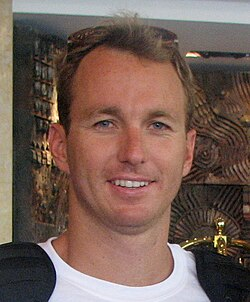

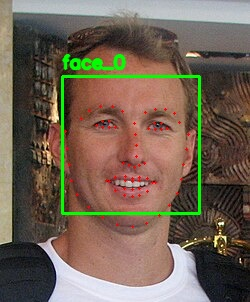

In [26]:
# =========================
# SHOW INSPECT IMAGE
# =========================
from PIL import Image
from IPython.display import display

img = Image.open(image_path)
display(img)

inspect_img = Image.open(out_image)
display(inspect_img)

In [27]:
# =========================
# COMPARE IMAGES
# =========================
def compare_two(
    image1: str,
    image2: str,
    threshold: float = 0.6,
    detect_model: str = "cnn",
    landmarks_model: str = "large",
    upsample: int = 0,
) -> None:
    def first_encoding(path: str) -> Optional[np.ndarray]:
        image_rgb = _load_image_rgb(path)
        boxes = _detect_faces(image_rgb, detect_model=detect_model, upsample=upsample)
        if not boxes:
            return None
        encs = _encode_faces(image_rgb, [boxes[0]], landmarks_model=landmarks_model)
        if not encs:
            return None
        return encs[0]

    enc1 = first_encoding(image1)
    enc2 = first_encoding(image2)

    if enc1 is None or enc2 is None:
        print("[COMPARE] Khong tao duoc encoding cho mot trong hai anh.")
        return

    dist = float(np.linalg.norm(enc1 - enc2))
    is_match = dist < threshold

    print(f"[COMPARE] distance_L2 = {dist:.6f}")
    print(f"[COMPARE] threshold   = {threshold:.3f}")
    print(f"[COMPARE] predict     = {'MATCH' if is_match else 'MISMATCH'}")

In [28]:
image1_path = TEST_DIR / "2.jpg"
image2_path = TEST_DIR / "3.jpg"
threshold = 0.6
detect_model = "cnn"
landmarks_model = "large"
upsample = 0

compare_two(
    image1 = image1_path,
    image2 = image2_path,
    threshold = threshold,
    detect_model = detect_model,
    landmarks_model = landmarks_model,
    upsample = upsample,
)

[COMPARE] distance_L2 = 0.439907
[COMPARE] threshold   = 0.600
[COMPARE] predict     = MATCH


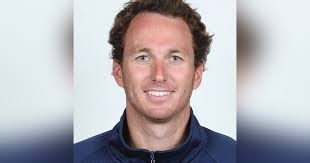

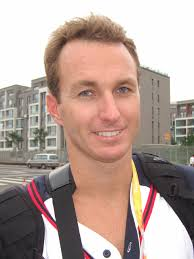

In [29]:
# =========================
# SHOW COMPARE IMAGES
# =========================
from PIL import Image
from IPython.display import display

img1 = Image.open(image1_path)
display(img1)

img2 = Image.open(image2_path)
display(img2)